<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Aprendizaje Supervisado -> Grupo 5 Cohorte 2</h1>

Patricia Loto

Sandra Monica Olariaga

Veronica Bornancini

Fernandez María Soledad   


# Diplodatos Kaggle Competition

We present this peace of code to create the baseline for the competition, and as an example of how to deal with these kind of problems. The main goals are that you:

1. Learn
2. Try different models and see which one fits the best the given data
3. Get a higher score than the given one in the current baseline example
4. Try to get the highest score in the class :)

In [1]:
# Import the required packages
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats 
import seaborn as sns 
import warnings

from sklearn.model_selection import train_test_split 
#from sklearn.neighbors import KNeighborsRegressor
#from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
#from sklearn.ensemble import ExtraTreesRegressor
#from xgboost import XGBRegressor
import xgboost as xgb
from IPython.display import display_html
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from imblearn.ensemble import BalancedBaggingClassifier

Read the *original* dataset...

In [2]:
original_df = pd.read_csv('../data/train.csv')
#original_df = pd.read_csv(r'E:\anaconda3\envs\aprendizajesupervisado\train.csv')

# 1. Learn

## 1.1 Verificamos columnas con sus datos

In [3]:
# 1) Averiguamos el nombre de cada variable presente en el dataset
original_df.columns

Index(['TripType', 'VisitNumber', 'Weekday', 'Upc', 'ScanCount',
       'DepartmentDescription', 'FinelineNumber'],
      dtype='object')

In [4]:
# 2) Inspeccionamos las primeras filas del dataset
original_df[:5]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,8,9,Friday,1.070081e+09,1,IMPULSE MERCHANDISE,115.0
2,8,9,Friday,3.107000e+03,1,PRODUCE,103.0
3,8,9,Friday,4.011000e+03,1,PRODUCE,5501.0
4,8,10,Friday,6.414410e+09,1,DSD GROCERY,2008.0


* **TripType** is the column that we should predict. That column is not present in the test set

In [5]:
# 3) Consultamos el tipo de dato de cada variable
original_df.dtypes

TripType                   int64
VisitNumber                int64
Weekday                   object
Upc                      float64
ScanCount                  int64
DepartmentDescription     object
FinelineNumber           float64
dtype: object

In [6]:
# 4) Pedimos una descripción de los datos. Por defecto se muestra la información de las variables numéricas
original_df.describe().round()

,TripType,VisitNumber,Upc,ScanCount,FinelineNumber
count,453411.0,453411.0,4.505590e+05,453411.0,450559.0
mean,58.0,95910.0,3.075243e+10,1.0,3727.0
std,156.0,55400.0,9.163940e+10,1.0,2780.0
min,3.0,5.0,8.340000e+02,-10.0,0.0
25%,27.0,49390.0,3.400004e+09,1.0,1404.0
50%,39.0,96781.0,7.056082e+09,1.0,3352.0
75%,40.0,143930.0,3.013201e+10,1.0,5501.0
max,999.0,191347.0,9.789707e+11,71.0,9998.0


In [7]:
# 5) Como tenemos variables tipo Object, pedimos ver un resumen del resto de los datos (no numéricos)
original_df.describe(include=['object'])

,Weekday,DepartmentDescription
count,453411,452439
unique,7,68
top,Sunday,GROCERY DRY GOODS
freq,94602,49134


In [8]:
# 6) Averiguamos los posibles valores que toman las variables tipo Object
# Variable Weekday
set(original_df.Weekday)

{'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'}

In [9]:
# Variable DepartmentDescription
set(original_df.DepartmentDescription)

{'1-HR PHOTO',
 'ACCESSORIES',
 'AUTOMOTIVE',
 'BAKERY',
 'BATH AND SHOWER',
 'BEAUTY',
 'BEDDING',
 'BOOKS AND MAGAZINES',
 'BOYS WEAR',
 'BRAS & SHAPEWEAR',
 'CAMERAS AND SUPPLIES',
 'CANDY, TOBACCO, COOKIES',
 'CELEBRATION',
 'COMM BREAD',
 'CONCEPT STORES',
 'COOK AND DINE',
 'DAIRY',
 'DSD GROCERY',
 'ELECTRONICS',
 'FABRICS AND CRAFTS',
 'FINANCIAL SERVICES',
 'FROZEN FOODS',
 'FURNITURE',
 'GIRLS WEAR, 4-6X  AND 7-14',
 'GROCERY DRY GOODS',
 'HARDWARE',
 'HEALTH AND BEAUTY AIDS',
 'HOME DECOR',
 'HOME MANAGEMENT',
 'HORTICULTURE AND ACCESS',
 'HOUSEHOLD CHEMICALS/SUPP',
 'HOUSEHOLD PAPER GOODS',
 'IMPULSE MERCHANDISE',
 'INFANT APPAREL',
 'INFANT CONSUMABLE HARDLINES',
 'JEWELRY AND SUNGLASSES',
 'LADIES SOCKS',
 'LADIESWEAR',
 'LARGE HOUSEHOLD GOODS',
 'LAWN AND GARDEN',
 'LIQUOR,WINE,BEER',
 'MEAT - FRESH & FROZEN',
 'MEDIA AND GAMING',
 'MENS WEAR',
 'MENSWEAR',
 'OFFICE SUPPLIES',
 'OPTICAL - FRAMES',
 'OPTICAL - LENSES',
 'OTHER DEPARTMENTS',
 'PAINT AND ACCESSORIES',
 'PER

In [10]:
# 7) Averiguaremos si hay valores nulos (nan)
# Cuantificamos por Tipo de Viaje (TripType)
s_triptype = original_df.groupby("VisitNumber").TripType.mean().value_counts()
df_triptype = s_triptype.to_frame(name="TripType")
df_triptype = df_triptype.sort_values('TripType')
df_triptype_styler = df_triptype.style.set_table_attributes("style='display:inline;padding-left:20px;'").set_caption('Cantidad por TRIPTYPE')

display_html(df_triptype_styler._repr_html_(), raw=True)

,TripType
14,4
23,98
12,187
4,245
19,252
29,313
28,331
26,355
18,384
41,412


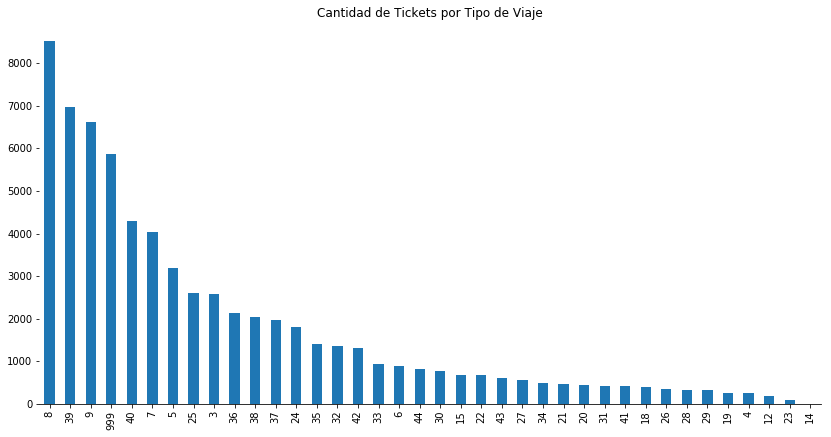

In [11]:
# 8) Agrupamos por VisitNumber para realizar un conteo de los valores de la variable TripType 
plt.figure (figsize=(14,7))
plt.title('Cantidad de Tickets por Tipo de Viaje')
sns.despine(left=True)
original_df.groupby("VisitNumber").TripType.mean().value_counts().plot(kind='bar')

* **Observación:** Los datos se encuentran desbalanceados con respecto a la cantidad de registros por TripType

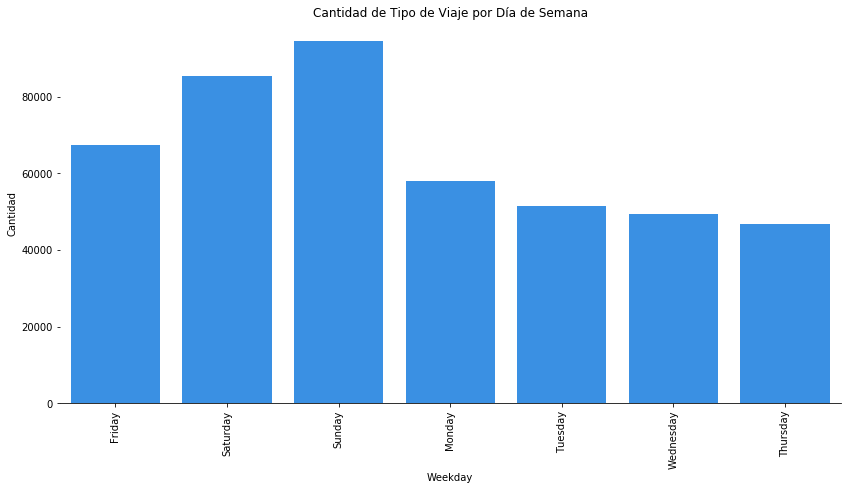

In [12]:
plt.figure (figsize=(14,7))
plt.title('Cantidad de Tipo de Viaje por Día de Semana')
sns.countplot(data=original_df, x='Weekday', color='dodgerblue')
plt.xticks(rotation=90)
plt.ylabel('Cantidad')
sns.despine(left=True)

## 1.2 Verificacion de Valores Nulos

In [13]:
# 1) Chequeamos si hay valores nulos y si es así cuantos hay
v_nan =np.zeros((7,1))

v_nan[0] = original_df.TripType.isnull().sum()
v_nan[1] = original_df.VisitNumber.isnull().sum()
v_nan[2] = original_df.Weekday.isnull().sum()
v_nan[3] = original_df.Upc.isnull().sum()
v_nan[4] = original_df.ScanCount.isnull().sum()
v_nan[5] = original_df.DepartmentDescription.isnull().sum()
v_nan[6] = original_df.FinelineNumber.isnull().sum()

df_nan = pd.DataFrame(v_nan, index=['TripType_NaN','VisitNumber_NaN','Weekday_NaN','Upc_NaN','ScanCount_NaN','DepartmentDescription_NaN','FinelineNumber_NaN']).round()
df_nan.columns = ['Nulos']

df_nan_styler = df_nan.style.set_table_attributes("style='display:inline;padding-left:20px;'").set_caption('Nulos en el DF')

display_html(df_nan_styler._repr_html_(), raw=True)

,Nulos
TripType_NaN,0
VisitNumber_NaN,0
Weekday_NaN,0
Upc_NaN,2852
ScanCount_NaN,0
DepartmentDescription_NaN,972
FinelineNumber_NaN,2852


In [14]:
# 2) Chequeamos si los registros con valores nulos se corresponden 
(original_df.DepartmentDescription.isnull().sum(),
 (original_df.DepartmentDescription.isnull() & original_df.Upc.isnull() & original_df.FinelineNumber.isnull()).sum()) # si es nan el departamento los otros dos atributos lo son

(972, 972)

* **Observaciones:** 
* Tenemos tres variables con valores nulos (Upc, DepartmentDescription y FinelineNumber).
* La cantidad de nulos para las variables Upc y FinelineNumber es el mismo.
* Verificamos que cuando DepartmentDescription es NaN, las columnas Upc y FinelineNumber también lo son.

In [15]:
original_df[original_df.Upc.isnull()]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
739,999,484,Friday,NaN,-2,NaN,NaN
740,999,484,Friday,NaN,-2,NaN,NaN
900,5,585,Friday,NaN,1,PHARMACY RX,NaN
944,5,619,Friday,NaN,1,PHARMACY RX,NaN
945,5,619,Friday,NaN,1,PHARMACY RX,NaN
946,5,619,Friday,NaN,1,PHARMACY RX,NaN
1292,32,845,Friday,NaN,1,NaN,NaN
1293,32,845,Friday,NaN,1,NaN,NaN
1577,40,1004,Friday,NaN,1,NaN,NaN
1770,5,1073,Friday,NaN,1,PHARMACY RX,NaN


In [16]:
(original_df.Upc.isnull().sum(),
 original_df.FinelineNumber.isnull().sum(),
 (original_df.FinelineNumber.isnull() & original_df.Upc.isnull()).sum())

(2852, 2852, 2852)

In [17]:
df_notna = original_df[pd.notnull(original_df['DepartmentDescription'])]
print(df_notna.FinelineNumber.isnull().sum())
print(df_notna.Upc.isnull().sum())

1880
1880


**Observaciones:** 
* Puede darse el caso que cuando la variable Upc es nula, la variable DepartmentDescription no lo sea.
* Notamos que los registros con valores nulos de las variables Upc y FinelineNumber se corresponden.
* La cantidad de registros con valores no nulos de ambas variables, también se corresponde.

## 1.3 Verificacion y eliminacion de Outliers

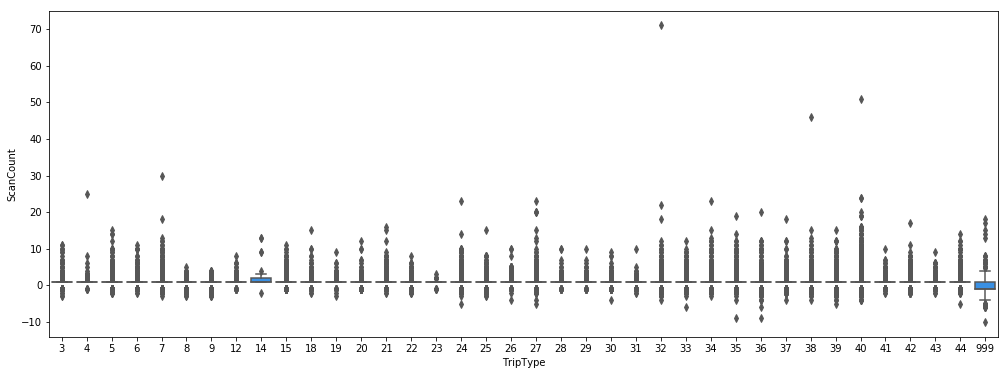

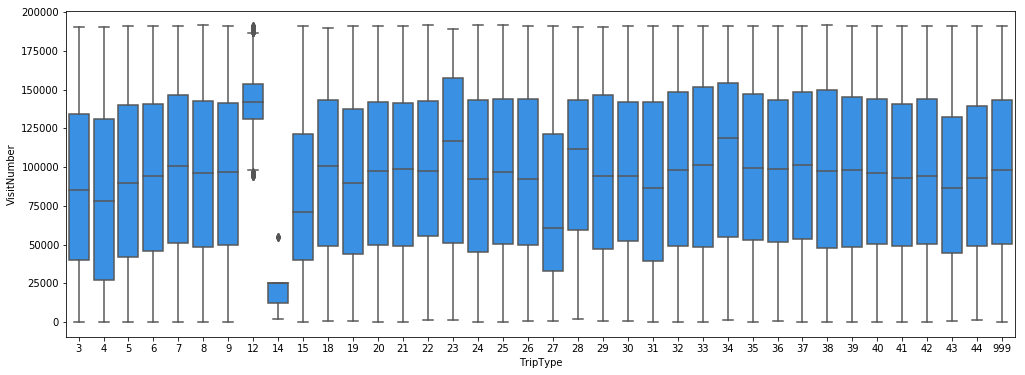

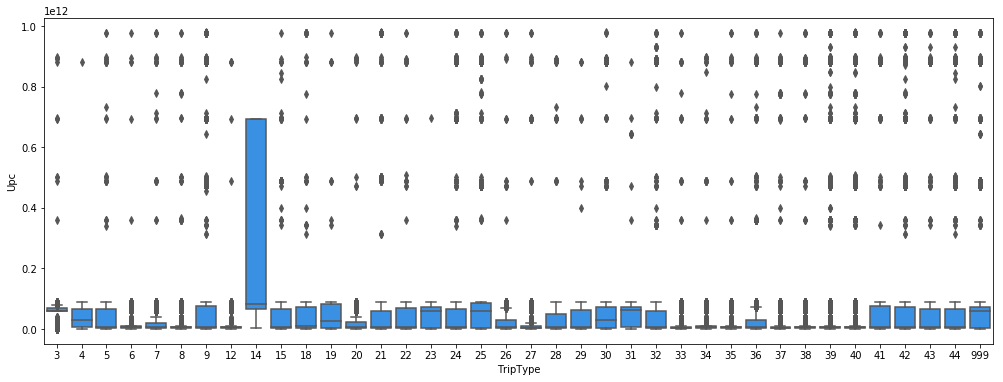

In [18]:
# 1) Seleccinamos las variables con el método .loc usando los nombres de las columnas
df_outl = df_notna.loc[:, ['TripType','ScanCount', 'VisitNumber', 'Upc']] 

# 2) Graficamos los boxplot para detectar outliers
for feature in df_outl.columns:
    
    if feature != 'TripType':
        plt.figure (figsize=(17,6))
        sns.boxplot(data=df_outl, color='dodgerblue', x='TripType', y=feature)
        plt.ylabel(feature)
        plt.xlabel('TripType')
        plt.show()

**Observaciones:**
* Podemos notar que para la variable **ScanCount** existen outliers para algunos Tipos de Viaje (TripType).
* Para la variable **VisitNumber** se detectan outliers en los Triptype 12 y 14, incluso podrian no ser outliers esos valores.
* La variable **Upc** posee muhcos outliers para la mayoría de los diferentes Triptype.

In [19]:
# 3) Filtramos los outliers 
def clean_outliers(dataset, column_name):
    """Returns dataset removing the outlier rows from column @column_name."""
    interesting_col = dataset[column_name]
    mask_var_outlier = (
        np.abs(interesting_col - interesting_col.mean()) <= (15 * interesting_col.std()))     # PORQUE DECÍA A 15 ??????
    return dataset[mask_var_outlier]

In [20]:
# Filtramos los outliers de la variable ScanCount
df_clean_ScanCount = clean_outliers(df_notna, "ScanCount")
print("Filas removidas", len(df_notna) - len(df_clean_ScanCount))

Filas removidas 100


In [21]:
# Filtramos los outliers de la variable VisitNumber
df_clean_VisitNumber = clean_outliers(df_clean_ScanCount, "VisitNumber")
print("Filas removidas", len(df_clean_ScanCount) - len(df_clean_VisitNumber))

Filas removidas 0


In [22]:
# Filtramos los outliers de la variable Upc
df_clean_Upc = clean_outliers(df_clean_VisitNumber, "Upc")
print("Filas removidas", len(df_clean_VisitNumber) - len(df_clean_Upc))

Filas removidas 1880


In [23]:
# Redefiimos el nombre del dataset y calculamos el total de filas removidas
df_clean = df_clean_Upc
print("Filas iniciales", len(df_notna))
print("Total de Filas removidas", len(df_notna) - len(df_clean))

Filas iniciales 452439
Total de Filas removidas 1980


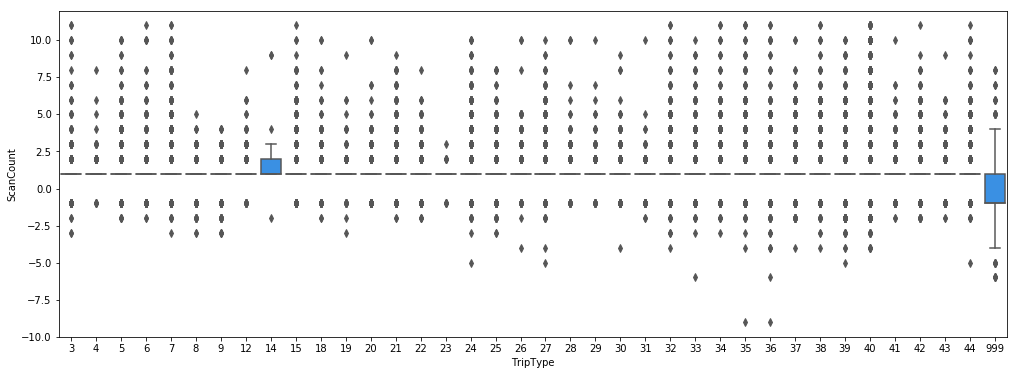

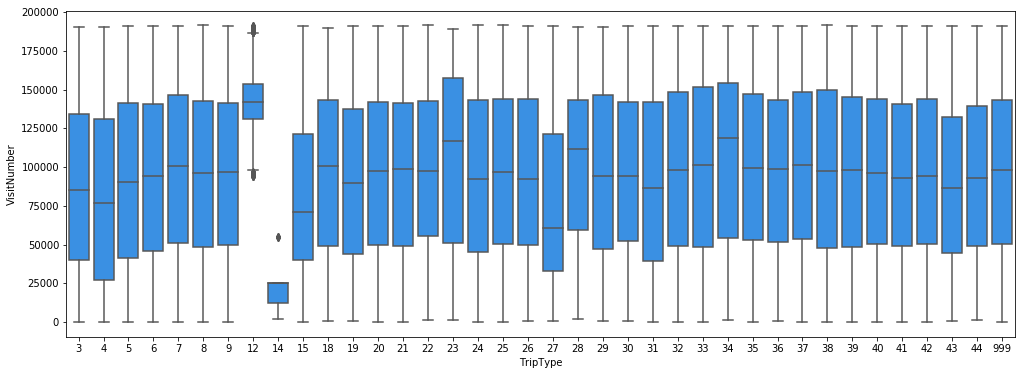

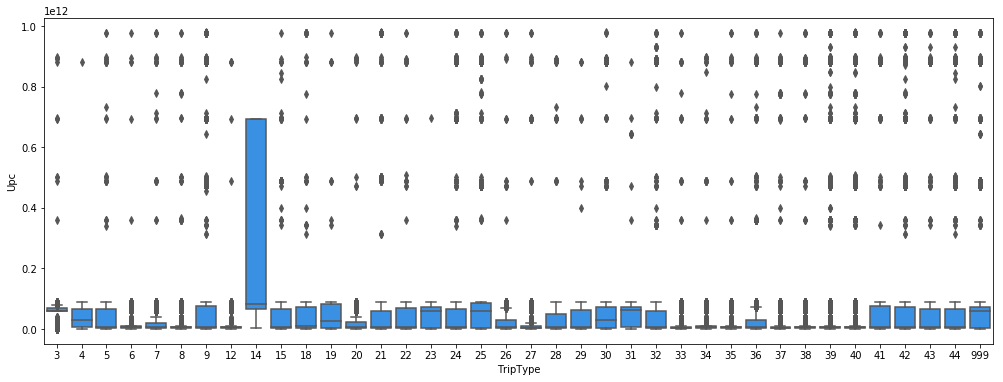

In [24]:
# 4) Graficamos los boxplot para corroborar la limpieza de los outliers
for feature in df_outl.columns:
    
    if feature != 'TripType':
        plt.figure (figsize=(17,6))
        sns.boxplot(data=df_clean, color='dodgerblue', x='TripType', y=feature)
        plt.ylabel(feature)
        plt.xlabel('TripType')
        plt.show()

In [25]:
# 5) Agrupamos los registros por VisitNumber
df_group = original_df.groupby(by='VisitNumber', as_index=False).agg({'Weekday': pd.Series.nunique})

print(df_group['Weekday'].unique())

[1]


**Observaciones:**
* Al agrupar por VisitNumber y verificar los valores de Weekday notamos que todos los tickets son únicos para la feature Weekday
* Indica que Cada Visitante realizó una única compra en un mismo día.

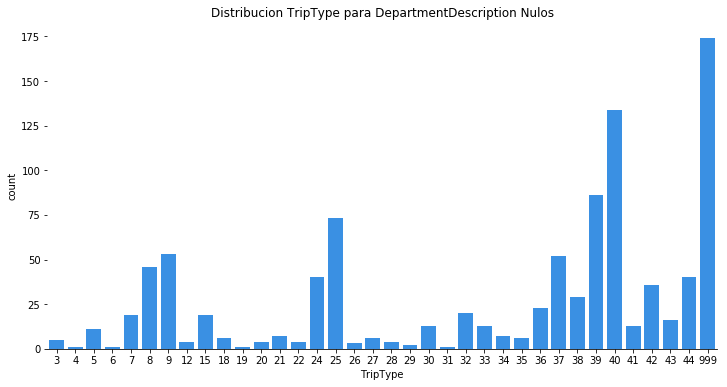

In [26]:
# 6) Guardamos en df_ddNaN, los regstros nulos para DepartmentDescription
df_ddNaN = original_df[original_df.DepartmentDescription.isnull()]

# Para realizar el conteo de los valores de la variable TripType, debemos agrupar a los visitantes por el VisitNumber
plt.figure (figsize=(12,6))
plt.title('Distribucion TripType para DepartmentDescription Nulos')
sns.despine(left=True)
sns.countplot(data=df_ddNaN, x='TripType', color='dodgerblue')

In [27]:
df_group = original_df.groupby(by='VisitNumber', as_index=False).agg({'TripType': pd.Series.nunique})

print(df_group['TripType'].unique())    

[1]


**Observaciones:** 
* Para el caso de **DepartmentDescription** vemos en el gráfico, que existe una distribucion no uniforme en la clasificacion de TripType 
* Al agrupar por **VisitNumber** y verificar los valores de TripType notamos tambien que todos los tickets son únicos para esta feature

In [28]:
# 7) Reemplazamos los NaN de la feature UPC por la moda ya que se trata de una variable numerica discreta
warnings.filterwarnings('ignore')
original_df.Upc.mode()[0]

df_notna.fillna({'Upc': original_df.Upc.mode()[0]}, inplace=True)
df_notna.Upc.isnull().sum()

0

In [29]:
y = original_df.groupby(["VisitNumber", "Weekday"], as_index=False).max().TripType
y.shape

(67029,)

Our last step in this analysis is to see how balanced is the data...

In [30]:
bins = set(original_df.TripType) ###### esto para que es

Create a function to load the datasets.

## 1.4  Consideraciones Importantes:
* **1)** Usaremos **One hot encoding** para las variables **Weekday** y **DepartmentDescription**. Todas las transformaciones son aplicadas a los sets de Train y Test.
* **2)** Filtramos los valores nulos de **DepartmentDescription** y **Upc**.
* **3)** No utilizaremos la variable **FinelineNumber** ya que no la consideramos relevante para el proceso.
* **4)** Reemplazamos los valores nulos de la variable **Upc** por la moda, ya que se trata de una variable numérica discreta.
* **5)** Es posible que tengamos varios registros para una sola visita (VisitNumber) y el objetivo es clasificar todos esos registros exactamente de la misma manera. Por tanto, prepararemos los datos de forma que toda la información de una visita quede en el mismo registro.
* **6)** Eliminaremos los outliers de las variables **ScanCount** y **Upc** con más de 15 desviaciones de la media
* **7)** Contaremos la variable **DepartmentDescription** para todos los artículos adquiridos en la misma visita.
* **8)** Para probar los distintos modelos tomaremos la mitad del dataset en forma aleatoria.

The following operations will be performed in a function. Anyway, we present them here so that we can see them in action:

First, we drop the columns. We include TripType as we are going to treat it differently:

In [31]:
# Las siguientes operaciones se realizarán en una función. 
# De todos modos, aquí los presentamos para que podamos verlos en acción:

# 1) Primero eliminamos la variable FinelineNumber, e incluimos a la variable TripType:
df = original_df.drop(["FinelineNumber", "TripType"], axis=1)
df

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription
0,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES
1,9,Friday,1.070081e+09,1,IMPULSE MERCHANDISE
2,9,Friday,3.107000e+03,1,PRODUCE
3,9,Friday,4.011000e+03,1,PRODUCE
4,10,Friday,6.414410e+09,1,DSD GROCERY
5,10,Friday,2.800054e+09,1,"CANDY, TOBACCO, COOKIES"
6,10,Friday,7.794801e+09,1,DSD GROCERY
7,11,Friday,4.178901e+09,1,GROCERY DRY GOODS
8,11,Friday,7.800002e+09,1,DSD GROCERY
9,11,Friday,2.840028e+09,1,IMPULSE MERCHANDISE


In [32]:
# 2) Creamos las variables Dummies para la variable DepartmentDescription
df = pd.get_dummies(df, columns=["DepartmentDescription"], dummy_na=True)
df

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,...,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_nan
0,5,Friday,6.811315e+10,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,Friday,1.070081e+09,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,Friday,3.107000e+03,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,Friday,4.011000e+03,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,Friday,6.414410e+09,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,10,Friday,2.800054e+09,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,10,Friday,7.794801e+09,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,11,Friday,4.178901e+09,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,11,Friday,7.800002e+09,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,11,Friday,2.840028e+09,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# 3) Agrupamos por VisitNumber y Weekday (deberían ser iguales), y agregamos todos los valores para ScanCount y la codificación one-hot de DepartmentDescription
df = df.groupby(["VisitNumber", "Weekday"], as_index=False).sum()
df

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,...,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_nan
0,5,Friday,6.811315e+10,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,Friday,1.070088e+09,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10,Friday,1.700927e+10,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,Friday,2.273895e+10,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,Friday,1.832173e+11,7,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,17,Friday,9.820019e+09,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,20,Friday,7.530530e+10,3,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7,26,Friday,4.403676e+11,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,28,Friday,9.993243e+11,8,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
9,29,Friday,1.200001e+09,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# 4) Creamos las variables Dummies para la variable Weekday
df = pd.get_dummies(df, columns=["Weekday"], dummy_na=True)
df

,VisitNumber,Upc,ScanCount,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,...,DepartmentDescription_WIRELESS,DepartmentDescription_nan,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Weekday_nan
0,5,6.811315e+10,-1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,9,1.070088e+09,3,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,10,1.700927e+10,3,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,11,2.273895e+10,4,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,12,1.832173e+11,7,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,17,9.820019e+09,4,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,20,7.530530e+10,3,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,26,4.403676e+11,12,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,28,9.993243e+11,8,0,0,0,2,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,29,1.200001e+09,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


**Observación:**
* La funcion que creemos contendrá los puntos definidos para cada una de las decisiones que se tomaron sobre el dataset

In [35]:
def transform_data(train_data_fname, test_data_fname):
    
    df_train = pd.read_csv(train_data_fname)
    y = df_train
    df_train['is_train_set'] = 1
    df_test = pd.read_csv(test_data_fname)
    df_test['is_train_set'] = 0
    
    # Para el set de test saco los valores nulos de la variable DepartmentDescription
    y = y[pd.notnull(y['DepartmentDescription'])]
    
    # Elimino los outliers
    y_clean = clean_outliers(y, "ScanCount")
    y = y_clean
    
    # Agrupo el dataset por VisitNumber y obtengo el máximo
    y = y.groupby(["VisitNumber", "Weekday"], as_index=False).max().TripType
    
    # Utilizamos la función concat para mantener el ismo número de columas en ambos conjuntos de datos (train y test)
    df = pd.concat([df_train, df_test])
    
    # Eliminamos los valores nulos de la columna DepartmentDescription
    df_notna = df[pd.notnull(df['DepartmentDescription'])]
    
    # Eliminamos la variable FinelineNumber (ya que no la utilizaremos en el análisis)
    df_notna = df_notna.drop(["FinelineNumber"], axis=1)
    
    # Reemplazamos los valores faltantes de Upc por la Moda
    df_notna.fillna({'Upc': original_df.Upc.mode()[0]}, inplace=True)

    # Aplicamos one-hot encoding para la variable DepartmentDescription
    df_notna = pd.get_dummies(df_notna, columns=["DepartmentDescription"], dummy_na=True)
    
    # Eliminamos los outliers de ScanCount
    df_clean = clean_outliers(df_notna, "ScanCount")
            
    # Agregamos los valores agrupados
    df_clean = df_clean.groupby(["VisitNumber", "Weekday"], as_index=False).sum()
    
    # Aplicamos one-hot encoding para la variable Weekday
    df_clean = pd.get_dummies(df_clean, columns=["Weekday"], dummy_na=True)

    # Obtenemos los sets de Entrenamiento y Evaluación (Train y Test)
    df_train = df_clean[df_clean.is_train_set != 0]
    df_test = df_clean[df_clean.is_train_set == 0]

    # Eliminamos la variable TripType y concatenamos ambos sets de datos
    df_train = df_train.drop("TripType", axis=1)
    df_test = df_test.drop("TripType", axis=1)
    
    X = df_train.drop(["is_train_set"], axis=1)
    yy = None
    XX = df_test.drop(["is_train_set"], axis=1)

    return X, y, XX, yy

In [36]:
# Cargamos la información del dataset
X, y, XX, yy = transform_data("../data/train.csv", "../data/test.csv")

In [37]:
X.shape, y.shape, XX.shape

((66908, 80), (66908,), (28596, 80))

### 2. Try different models and see which one fits the best the given data

**DESBALANCEO DE DATOS**
Podemos optar por alguno de estos dos metodos para balancearlos

*Ajuste de Parámetros del modelo*: Consiste en ajustar parametros ó metricas del propio algoritmo para intentar equilibrar a la clase minoritaria penalizando a la clase mayoritaria durante el entrenamiento. Ejemplos on ajuste de peso en árboles, también en logisticregression tenemos el parámetro class_weight= “balanced” que utilizaremos en este ejemplo. No todos los algoritmos tienen estas posibilidades. En redes neuronales por ejemplo podríamos ajustar la métrica de Loss para que penalice a las clases mayoritarias.

*Balanced Ensemble Methods*: Utiliza las ventajas de hacer ensamble de métodos, es decir, entrenar diversos modelos y entre todos obtener el resultado final (por ejemplo “votando”) pero se asegura de tomar muestras de entrenamiento equilibradas.

Create the model and evaluate it

#### 2.1 Dividir los dataset en entrenamiento y test

In [38]:
# split training dataset into train and "validation" 
# (we won't be using validation set in this example, because of the cross-validation;
# but it could be useful for you depending on your approach)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=0)

In [39]:
# results dataframe is used to store the computed results
res_acc_df = pd.DataFrame(columns=('description', 'clf', 'best_acc'))

#### 2.2 Modelo Decision Tree

##### 2.2.1 Setear Hiperparametros, entrenar y seleccionar el Mejor Modelo

In [40]:
# we will use a DesicionTree to classify and GridSearch to determine the parameters
tree_param = {
              'criterion':('gini', 'entropy'), 
              'min_samples_leaf':(1, 2, 5),
              'min_samples_split':(2, 3, 5, 10, 50, 100),
              'random_state':(0, 1, 2, 42)
             }

model_tree = DT()

tree_clf = GridSearchCV(model_tree, tree_param, cv=3, scoring='accuracy') #scoring='balanced_accuracy')

In [41]:
tree_clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('gini', 'entropy'),
                         'min_samples_leaf': (1, 2, 5),
                         'min_samples_split': (2, 3, 5, 10, 50, 100),
                         'random_state': (0, 1, 2, 42)},
             scoring='accuracy')

In [42]:
# results dataframe is used to store the computed results
results = tree_clf.cv_results_
    
df = pd.DataFrame(results)
df_result = df[['param_criterion', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']]
df_result

,param_criterion,param_min_samples_leaf,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
0,gini,1,2,0.586058,0.005315,84
1,gini,1,2,0.584883,0.004350,101
2,gini,1,2,0.585481,0.003075,95
3,gini,1,2,0.585566,0.004293,90
4,gini,1,3,0.586634,0.004198,78
5,gini,1,3,0.585631,0.003869,85
6,gini,1,3,0.586292,0.005465,79
7,gini,1,3,0.586762,0.004181,77
8,gini,1,5,0.588662,0.004304,76
9,gini,1,5,0.589730,0.004604,74


In [43]:
# Seleccionar el modelo con mean_test_score mas alto y menor varianza
df_bm = df_result[df_result['rank_test_score'] == 1]
df_bm

,param_criterion,param_min_samples_leaf,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
68,gini,5,100,0.639031,0.004319,1
69,gini,5,100,0.639031,0.004319,1
70,gini,5,100,0.639031,0.004319,1


In [44]:
best_tree_clf = tree_clf.best_estimator_
bestpar = tree_clf.best_params_

print('Mejor Modelo\n', best_tree_clf)
print('Mejores Parametros\n', bestpar)

Mejor Modelo
 DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=100,
                       random_state=0)
Mejores Parametros
 {'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 100, 'random_state': 0}


In [45]:
print('Best Decision Tree accuracy: ', tree_clf.best_score_)
res_acc_df = res_acc_df.append({'description': 'modelo dt first run', 'clf': best_tree_clf, 'best_acc': tree_clf.best_score_}, ignore_index=True)

Best Decision Tree accuracy:  0.6390307572276194


In [46]:
res_acc_df

,description,clf,best_acc
0,modelo dt first run,"DecisionTreeClassifier(min_samples_leaf=5, min...",0.639031


#### 2.3 Modelo Naive Bayes

##### 2.3.1 Setear Hiperparametros, entrenar y seleccionar el Mejor Modelo

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=0)

In [48]:
X_train.ScanCount[X_train.ScanCount < 0 ] = 0

In [49]:
modelNB = MultinomialNB().fit(X_train, y_train)

In [50]:
X_train.shape, y_train.shape

((40144, 80), (40144,))

In [51]:
y_train_pred=modelNB.predict(X_train)

In [52]:
acc_score = accuracy_score(y_train, y_train_pred)

print('Naive Bayes accuracy: ', acc_score)
res_acc_df = res_acc_df.append({'description': 'modelo nv second run', 'clf': 'default', 'best_acc': acc_score}, ignore_index=True)

Naive Bayes accuracy:  0.1208150657632523


In [53]:
res_acc_df

,description,clf,best_acc
0,modelo dt first run,"DecisionTreeClassifier(min_samples_leaf=5, min...",0.639031
1,modelo nv second run,default,0.120815


#### 2.4 Modelo Random Forest

##### 2.4.1 Setear Hiperparametros, entrenar y seleccionar el Mejor Modelo

In [54]:
rf_param = {
              'criterion':('gini', 'entropy'), 
              'min_samples_leaf':(1, 2, 5),
              'min_samples_split':(2, 3, 5, 10, 50, 100),
              'random_state': [0,1,2],
              'n_estimators': [50,75,100],
              'class_weight' : ('balanced', 'balanced_subsample')
            }

model_rf = RandomForestClassifier()
rf_clf = GridSearchCV(model_rf, rf_param, cv=3, scoring='accuracy') #scoring='balanced_accuracy')

In [ ]:
rf_clf.fit(X_train, y_train)

In [ ]:
# results dataframe is used to store the computed results
results = rf_clf.cv_results_
    
df = pd.DataFrame(results)
df_result = df[['param_criterion', 'param_min_samples_leaf', 'param_min_samples_split', 'param_random_state', 'param_n_estimators', 'param_class_weight', 'mean_test_score', 'std_test_score', 'rank_test_score']]
df_result

In [ ]:
# Seleccionar el modelo con mean_test_score mas alto y menor varianza
df_bm = df_result[df_result['rank_test_score'] == 1]
df_bm

In [ ]:
best_rf_clf = rf_clf.best_estimator_
bestpar = rf_clf.best_params_

print('Mejor Modelo\n', best_rf_clf)
print('Mejores Parametros\n', bestpar)

In [ ]:
print('Best Regression Logistic accuracy: ', rf_clf.best_score_)
res_acc_df = res_acc_df.append({'description': 'modelo rf third run', 'clf': rf_clf, 'best_acc': rf_clf.best_score_}, ignore_index=True)

In [ ]:
res_acc_df

#### 2.5 Modelo Boosting with xgboost

##### 2.5.1 Setear Hiperparametros, entrenar y seleccionar el Mejor Modelo

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
xg_reg.fit(X_train,y_train)

In [ ]:
y_train_pred = xg_reg.predict(X_train)

In [ ]:
mse = mean_squared_error(y_train, y_train_pred)
print("MSE: %f" % (mse))

In [ ]:
y_valid_pred = xg_reg.predict(X_valid)

In [ ]:
y_valid.shape, y_valid_pred.shape

In [ ]:
pred=[round(value) for value in y_valid_pred]

In [ ]:
acc_score = accuracy_score(y_valid, pred)

In [ ]:
print('Boosting accuracy: ', acc_score)
res_acc_df = res_acc_df.append({'description': 'modelo boosting fourth run', 'objective =reg:squarederror, colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10': 'default', 'best_acc': acc_score}, ignore_index=True)

In [ ]:
res_acc_df

In [ ]:
X.shape, XX.shape

#### 2.6 Modelo Ensemble with DT

##### 2.6.1 Setear Hiperparametros, entrenar y seleccionar el Mejor Modelo

In [ ]:
bbc = BalancedBaggingClassifier(base_estimator=DT(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

In [ ]:
#Train the classifier.
bbc.fit(X_train, y_train)

In [ ]:
y_valid_pred = bbc.predict(X_valid)

In [ ]:
y_valid.shape, y_valid_pred.shape

In [ ]:
pred=[round(value) for value in y_valid_pred]

In [ ]:
acc_score = accuracy_score(y_valid, pred)

In [ ]:
print('Ensemble accuracy: ', acc_score)
res_acc_df = res_acc_df.append({'description': 'modelo ensemble fifth run', 'clf': 'base_estimator=DT(), sampling_strategy=auto, replacement=False, random_state=0', 'best_acc': acc_score}, ignore_index=True)

**And finally**, we predict the unknown label for the testing set

The last thing we do is generating a file that should be *submitted* on kaggle

In [ ]:
#submission = pd.DataFrame(list(zip(XX.VisitNumber, yy)), columns=["VisitNumber", "TripType"])

In [ ]:
#submission.to_csv("../data/submission.csv", header=True, index=False)

In [ ]:
#submission